In [ ]:
# -------------------------------------------------- #
# Author: Jiayu Yang
# Date: 15 May 2023
# File Name: [Project CD] 1D FEM Galerkin & Petrov Galerkin Approximation Scheme
# File Description: 
#    This file aims at solving the 1D steady convection-diffusion problems using the
#    Finite Element Method (FEM) with respectively:
#        - Galerkin Approximation Scheme
#        - Petrov-Galerkin Approximation Scheme
#    The comparison of stability is also included.
# Web Link to Github: https://github.com/LakeYang0818/Solving-Convection-Diffusion-Problems
# -------------------------------------------------- #

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import mpmath

In [2]:
def exact_solver(a, mu, s, u0, uN, N):
    xmesh = np.zeros(N)  # Mesh size (Delta_x)
    xmesh = list(i / N for i in range(N + 1)) # Mesh point
    
    u_exact = np.zeros(N + 1)
    for i in range(N + 1):
        u_exact[i] = - s / (a * (np.exp(a / mu) - 1)) * (np.exp(a * xmesh[i] / mu) - 1) + s * xmesh[i] / a
    return u_exact

In [3]:
# Basis Functions
def phi(k: int, N):
    xmesh = np.zeros(N)  # Mesh point
    xmesh = list(i / N for i in range(len(xmesh) + 1))
    
    x_i = xmesh[k]
    x_l = xmesh[k - 1] if k != 0 else x_i
    x_r = xmesh[k + 1] if k != N else x_i
    step = lambda x: np.heaviside(x - x_l, 1) - np.heaviside(x - x_r, 0)
    return lambda x: step(x) * (1 - np.abs(x - x_i) * N)

# -------------------FEM Methods Pool------------------- #
def FEM_Galerkin(a, mu, s, u0, uN, N):
    xmesh = np.zeros(N)  # Mesh point
    xmesh = list(i / N for i in range(len(xmesh) + 1))
    
    # Galerkin Matrix A
    A = np.zeros((N + 1, N + 1))
    # Source S
    S = np.ones(N - 1) * s / N
    
    A_left  = - a / 2 - mu * N
    A_mid   = 2 * mu * N
    A_right = + a / 2 - mu * N
    
    for i in range(N + 1):
        if i == 0:
            A[i,   i  ] = A_mid
            A[i, i + 1] = A_right
        
        elif i == N:
            A[i, i - 1] = A_left
            A[i,   i  ] = A_mid
            
        else:
            A[i, i - 1] = A_left
            A[i,   i  ] = A_mid
            A[i, i + 1] = A_right
            
    A = A[1:-1, 1:-1]

    u_sol = np.zeros(N + 1)
    u_sol[1:-1] = np.linalg.solve(A, S)
    u_sol[0, ]  = u0
    u_sol[-1, ] = uN
    
    return list(phi(k, N)(xmesh[k]) * u_sol[k] for k in range(N + 1))

# -------------------Petrov Galerkin Scheme------------------- #
def FEM_Petrov_Galerkin(a, mu, s, u0, uN, N):
    xmesh = np.zeros(N)  # Mesh point
    xmesh = list(i / N for i in range(len(xmesh) + 1))
    
    Pe = a / (2 * mu * N)
    beta = mpmath.coth(Pe) - 1 / Pe
    tau = beta / (2 * abs(a) * N)
    
    # Petrov Galerkin Matrix A
    A = np.zeros((N + 1, N + 1))
    # Source S
    S = np.ones(N - 1) * s / N
    
    A_left  = - a / 2 - mu * N - tau * (a ** 2) * N
    A_mid   = + 2 * mu * N + 2 * tau * (a ** 2) * N
    A_right = + a / 2 - mu * N - tau * (a ** 2) * N
    
    for i in range(N + 1):
        if i == 0:
            A[i,   i  ] = A_mid
            A[i, i + 1] = A_right 
        
        elif i == N:
            A[i, i - 1] = A_left
            A[i,   i  ] = A_mid
            
        else:
            A[i, i - 1] = A_left
            A[i,   i  ] = A_mid
            A[i, i + 1] = A_right
            
    A = A[1:-1, 1:-1]

    u_sol = np.zeros(N + 1)
    u_sol[1:-1] = np.linalg.solve(A, S)
    u_sol[0, ]  = u0
    u_sol[-1, ] = uN
    
    return list(phi(k, N)(xmesh[k]) * u_sol[k] for k in range(N + 1))

In [4]:
def simple_plot(method, a, mu, s, u0, uN, N, save):
    # X-axis
    xmesh = np.zeros(N)  # Mesh point
    xmesh = list(i / N for i in range(len(xmesh) + 1))
    
    # Peclet number
    Pe = a / (2 * mu * N)
    
    # Exact Solution
    u_exact = exact_solver(a, mu, s, u0, uN, N)
    
    # Numerical Solution
    if method == 'FEM Galerkin Scheme':
        u_numerical = FEM_Galerkin(a, mu, s, u0, uN, N)
        
    elif method == 'FEM Petrov Galerkin Scheme':
        u_numerical = FEM_Petrov_Galerkin(a, mu, s, u0, uN, N)
    
    plt.plot(xmesh, u_numerical, color = 'red',  marker = 'o',label = method)
    plt.plot(xmesh, u_exact, color = 'blue', linestyle='--', marker = 'o', label = 'Exact')
    plt.title('%s v/s Exact Solution \n at $N = %s, P_e = %s$'%(method, N, Pe))
    plt.xlabel('x')
    plt.ylabel('u(x)')
    plt.legend()
    if save == True:
        plt.savefig('/Users/pc/Desktop/[P2] Convection-Diffusion Problem/Images Pool/%s_Pe = %s_N = %s_Plot.png'%(method, Pe, N))
    plt.show()
    

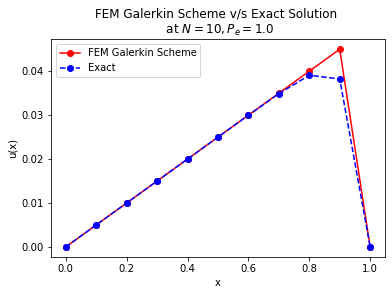

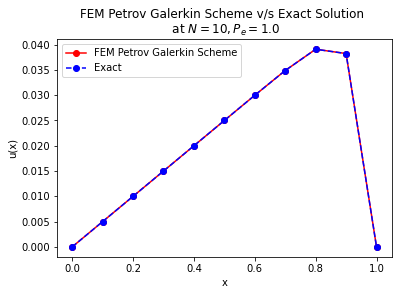

In [5]:
# Set up
a = 20
mu = 1
s = 1
u0 = 0
uN = 0
N = 10

# Simple Plot

simple_plot('FEM Galerkin Scheme', a, mu, s, u0, uN, N, False)
simple_plot('FEM Petrov Galerkin Scheme', a, mu, s, u0, uN, N, False)

In [6]:
# -----------------FDM Central Different Pe------------------#
def different_Pe_Plot(method, mu, s, u0, uN, N, save):
    # X-axis
    xmesh = np.zeros(N)  # Mesh point
    xmesh = list(i / N for i in range(len(xmesh) + 1))
    
    Pe_choice = [0.25, 0.5, 1, 5]
    
    if method == 'FEM Galerkin Scheme':
        for Pe in Pe_choice[:-1]:
            a = 2 * N * mu * Pe
            u_exact = exact_solver(a, mu, s, u0, uN, N)
            u_nodal = FEM_Galerkin(a, mu, s, u0, uN, N)
            u_numer = list(phi(k, N)(xmesh[k]) * u_nodal[k] for k in range(N + 1))
            
            plt.plot(xmesh, u_numer, color = 'red', marker = 'o')
            plt.plot(xmesh, u_exact, color = 'blue', linestyle='--', marker = 'o')
            plt.text(xmesh[2], u_exact[-7], 'Pe = %s'%Pe, bbox=dict(facecolor='white', alpha=0.8))
            
        Pe = Pe_choice[-1]
        a = 2 * N * mu * Pe
        u_exact = exact_solver(a, mu, s, u0, uN, N)
        u_nodal = FEM_Galerkin(a, mu, s, u0, uN, N)
        u_numer = list(phi(k, N)(xmesh[k]) * u_nodal[k] for k in range(N + 1))
        
        plt.plot(xmesh, u_numer, color = 'red', label = method)
        plt.plot(xmesh, u_exact, color = 'blue', linestyle='--', marker = 'o', label = 'Exact')
        plt.text(xmesh[2], u_exact[-10], 'Pe = %s'%Pe, bbox=dict(facecolor='white', alpha=0.8))
    
    elif method == 'FEM Petrov Galerkin Scheme':
        for Pe in Pe_choice[:-1]:
            a = 2 * N * mu * Pe
            u_exact = exact_solver(a, mu, s, u0, uN, N)
            u_nodal = FEM_Petrov_Galerkin(a, mu, s, u0, uN, N)
            u_numer = list(phi(k, N)(xmesh[k]) * u_nodal[k] for k in range(N + 1))
            
            plt.plot(xmesh, u_numer, color = 'red', marker = 'o')
            plt.plot(xmesh, u_exact, color = 'blue', linestyle='--', marker = 'o')
            plt.text(xmesh[2], u_exact[-7], 'Pe = %s'%Pe, bbox=dict(facecolor='white', alpha=0.8))
            
        Pe = Pe_choice[-1]
        a = 2 * N * mu * Pe
        u_exact = exact_solver(a, mu, s, u0, uN, N)
        u_nodal = FEM_Petrov_Galerkin(a, mu, s, u0, uN, N)
        u_numer = list(phi(k, N)(xmesh[k]) * u_nodal[k] for k in range(N + 1))
        
        plt.plot(xmesh, u_numer, color = 'red', label = method)
        plt.plot(xmesh, u_exact, color = 'blue', linestyle='--', marker = 'o', label = 'Exact')
        plt.text(xmesh[2], u_exact[-10], 'Pe = %s'%Pe, bbox=dict(facecolor='white', alpha=0.8))

    plt.title('%s v/s Exact Solution\nDifferent Peclet Number under N = %s'%(method, N))
    plt.xlabel('x')
    plt.ylabel('u(x)')
    plt.legend()
    if save == True:
        plt.savefig('/Users/pc/Desktop/[P2] Convection-Diffusion Problem/Images Pool/%s_N = %s under different Pe.png'%(method, N))
    plt.show()
    

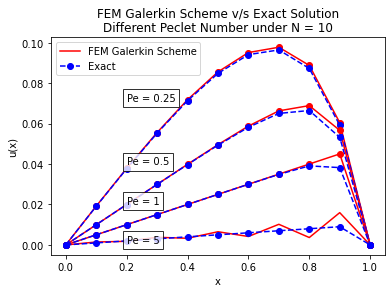

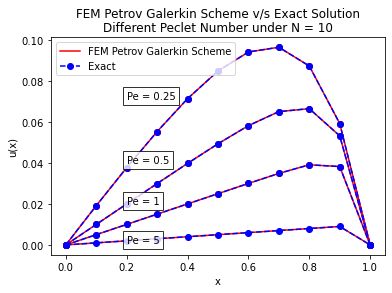

In [7]:
# Different Pe Plot

# Setup
mu = 1
s = 1
u0 = 0
uN = 0
N = 10

different_Pe_Plot('FEM Galerkin Scheme',    mu, s, u0, uN, N, False)
different_Pe_Plot('FEM Petrov Galerkin Scheme', mu, s, u0, uN, N, False)

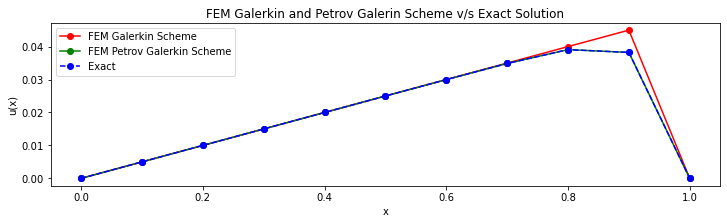

In [29]:
# -----------------Comparison of different schemes------------------#

# Setup
a = 20
mu = 1
s = 1
u0 = 0
uN = 0
N = 10
Pe = a / (2 * N * mu)

# X-Axis
xmesh = np.zeros(N)  # Mesh point
xmesh = list(i / N for i in range(len(xmesh) + 1))

u_exact = exact_solver(a, mu, s, u0, uN, N)
u_Ga = FEM_Galerkin(a, mu, s, u0, uN, N)
u_PG = FEM_Petrov_Galerkin(a, mu, s, u0, uN, N)

plt.rcParams["figure.figsize"] = (12,3)
plt.plot(xmesh, u_Ga, 'red', marker = 'o', label = 'FEM Galerkin Scheme')
plt.plot(xmesh, u_PG, 'green', marker = 'o', label = 'FEM Petrov Galerkin Scheme')
plt.plot(xmesh, u_exact, 'blue', linestyle='--', marker = 'o', label = 'Exact')
plt.title('FEM Galerkin and Petrov Galerin Scheme v/s Exact Solution')
plt.xlabel('x')
plt.ylabel('u(x)')
plt.legend()
#plt.savefig('/Users/shapixiaokeai/Desktop/[P2] Convection-Diffusion Problem/Images Pool/Comparison of FEM Galerkin and Petrov Galerin Scheme at Pe = %s N = %s.png'%(Pe, N))
plt.show()

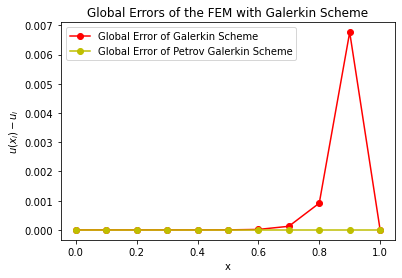

In [9]:
# Errors Plot
err_Galerkin = abs(u_Ga - u_exact)
err_Petrov_Galerkin = abs(u_PG - u_exact)

plt.plot(xmesh, err_Galerkin, 'r-', marker = 'o', label = 'Global Error of Galerkin Scheme')
plt.plot(xmesh, err_Petrov_Galerkin, 'y-', marker = 'o', label = 'Global Error of Petrov Galerkin Scheme')

plt.title('Global Errors of the FEM with Galerkin Scheme')
plt.xlabel('x')
plt.ylabel('$u(x_i) - u_i$')
plt.legend()
plt.show()

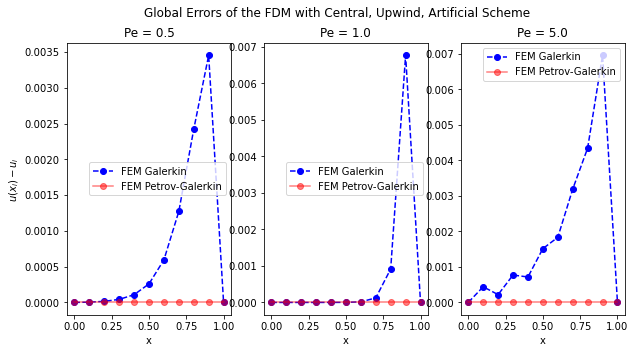

In [10]:
# Errors Plot

# Setup
a = 100
mu = 1
s = 1
u0 = 0
uN = 0
N = 10

# X-Axis
xmesh = np.zeros(N)  # Mesh point
xmesh = list(i / N for i in range(len(xmesh) + 1))

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 5))
fig.suptitle('Global Errors of the FDM with Central, Upwind, Artificial Scheme')

# First Plot
a = 10    
Pe = a / (2 * N * mu)

u_exact = exact_solver(a, mu, s, u0, uN, N)
u_Ga = FEM_Galerkin(a, mu, s, u0, uN, N)
u_PG = FEM_Petrov_Galerkin(a, mu, s, u0, uN, N)

err_Ga = abs(u_Ga - u_exact)
err_PG = abs(u_PG - u_exact)

ax1.plot(xmesh, err_Ga, 'b', linestyle = '--', marker = 'o', label = 'FEM Galerkin')
ax1.plot(xmesh, err_PG, 'r', marker = 'o', alpha = 0.5, label = 'FEM Petrov-Galerkin')
ax1.set_title('Pe = %s'%Pe)
ax1.set_xlabel('x')
ax1.set_ylabel('$u(x_i) - u_i$')
ax1.legend()

# Second Plot
a = 20
Pe = a / (2 * N * mu)

u_exact = exact_solver(a, mu, s, u0, uN, N)
u_Ga = FEM_Galerkin(a, mu, s, u0, uN, N)
u_PG = FEM_Petrov_Galerkin(a, mu, s, u0, uN, N)

err_Ga = abs(u_Ga - u_exact)
err_PG = abs(u_PG - u_exact)

ax2.plot(xmesh, err_Ga, 'b', linestyle = '--', marker = 'o', label = 'FEM Galerkin')
ax2.plot(xmesh, err_PG, 'r', marker = 'o', alpha = 0.5, label = 'FEM Petrov-Galerkin')
ax2.set_title('Pe = %s'%Pe)
ax2.set_xlabel('x')
ax2.legend()

# Third Plot
a = 100
Pe = a / (2 * N * mu)

u_exact = exact_solver(a, mu, s, u0, uN, N)
u_Ga = FEM_Galerkin(a, mu, s, u0, uN, N)
u_PG = FEM_Petrov_Galerkin(a, mu, s, u0, uN, N)

err_Ga = abs(u_Ga - u_exact)
err_PG = abs(u_PG - u_exact)

ax3.plot(xmesh, err_Ga, 'b', linestyle = '--', marker = 'o', label = 'FEM Galerkin')
ax3.plot(xmesh, err_PG, 'r', marker = 'o', alpha = 0.5, label = 'FEM Petrov-Galerkin')
ax3.set_title('Pe = %s'%Pe)
ax3.set_xlabel('x')
ax3.legend()

#plt.savefig('/Users/pc/Desktop/[P2] Convection-Diffusion Problem/Images Pool/Global Errors of FDM Artificial and Upwind Difference Scheme.png')
plt.show()

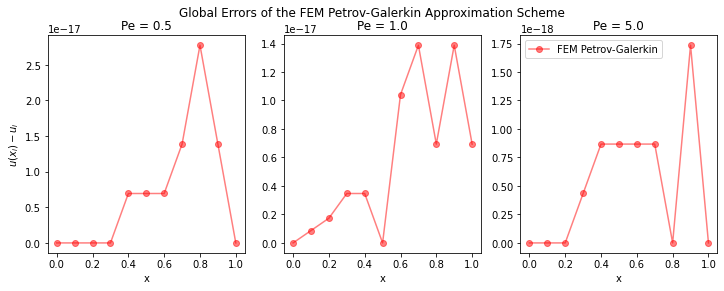

In [16]:
# Errors Plot

# Setup
a = 100
mu = 1
s = 1
u0 = 0
uN = 0
N = 10

# X-Axis
xmesh = np.zeros(N)  # Mesh point
xmesh = list(i / N for i in range(len(xmesh) + 1))

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))
fig.suptitle('Global Errors of the FEM Petrov-Galerkin Approximation Scheme')

# First Plot
a = 10    
Pe = a / (2 * N * mu)

u_exact = exact_solver(a, mu, s, u0, uN, N)
u_PG = FEM_Petrov_Galerkin(a, mu, s, u0, uN, N)

err_PG = abs(u_PG - u_exact)

ax1.plot(xmesh, err_PG, 'r', marker = 'o', alpha = 0.5)
ax1.set_title('Pe = %s'%Pe)
ax1.set_xlabel('x')
ax1.set_ylabel('$u(x_i) - u_i$')

# Second Plot
a = 20
Pe = a / (2 * N * mu)

u_exact = exact_solver(a, mu, s, u0, uN, N)
u_PG = FEM_Petrov_Galerkin(a, mu, s, u0, uN, N)

err_PG = abs(u_PG - u_exact)

ax2.plot(xmesh, err_PG, 'r', marker = 'o', alpha = 0.5)
ax2.set_title('Pe = %s'%Pe)
ax2.set_xlabel('x')

# Third Plot
a = 100
Pe = a / (2 * N * mu)

u_exact = exact_solver(a, mu, s, u0, uN, N)
u_PG = FEM_Petrov_Galerkin(a, mu, s, u0, uN, N)

err_PG = abs(u_PG - u_exact)

ax3.plot(xmesh, err_PG, 'r', marker = 'o', alpha = 0.5, label = 'FEM Petrov-Galerkin')
ax3.set_title('Pe = %s'%Pe)
ax3.set_xlabel('x')
ax3.legend()

#plt.savefig('/Users/shapixiaokeai/Desktop/[P2] Convection-Diffusion Problem/Images Pool/Global Errors of FEM Petrov-Galerkin Approximation Scheme.png')
plt.show()

In [23]:
# -----------------FDM Central Different Pe------------------#
def different_Pe_different_methods_Plot(mu, s, u0, uN, N, save):
    xmesh = np.zeros(N)  # Mesh point
    xmesh = list(i / N for i in range(len(xmesh) + 1))   
    Pe_choice = [5, 10, 20, 50]
    
    
    plt.figure(figsize = (15, 4))
    for Pe in Pe_choice[:-1]:
        a = 2 * N * mu * Pe
        u_exact = exact_solver(a, mu, s, u0, uN, N)
        u_Ga = FEM_Galerkin(a, mu, s, u0, uN, N)
        u_PG = FEM_Petrov_Galerkin(a, mu, s, u0, uN, N)

        plt.plot(xmesh, u_exact, color = 'blue', marker = 'o')
        
        plt.plot(xmesh, u_Ga, color = 'red', linestyle='-')
        plt.plot(xmesh, u_PG, color = 'green', linestyle='-')

        plt.text(xmesh[2], u_exact[-7], 'Pe = %s'%Pe, bbox=dict(facecolor='white', alpha=0.8))

    Pe = Pe_choice[-1]
    a = 2 * N * mu * Pe
    
    u_exact = exact_solver(a, mu, s, u0, uN, N)
    u_Ga = FEM_Galerkin(a, mu, s, u0, uN, N)
    u_PG = FEM_Petrov_Galerkin(a, mu, s, u0, uN, N)
    
    plt.plot(xmesh, u_exact, color = 'blue', marker = 'o', label = 'Exact')

    plt.plot(xmesh, u_Ga, color = 'red',   linestyle='-', label = 'FEM Galerkin')
    plt.plot(xmesh, u_PG, color = 'green', linestyle='-', label = 'FEM Petrov Galerkin')
        
    plt.text(xmesh[2], u_exact[-10], 'Pe = %s'%Pe, bbox=dict(facecolor='white', alpha=0.8))
    
    plt.title('FEM Schemes Under Different Peclet Number at N = %s'%N)
    plt.xlabel('x')
    plt.ylabel('u(x)')
    plt.legend()
    if save == True:
        plt.savefig('/Users/shapixiaokeai/Desktop/[P2] Convection-Diffusion Problem/Images Pool/Differnt FEM Schemes under different Pe at N = %s.png'%N)
    plt.show()
    

/var/folders/kw/h_nrm_y92yn6h074z_crl2000000gn/T/ipykernel_14347/1832087793.py:7: RuntimeWarning: overflow encountered in exp
  u_exact[i] = - s / (a * (np.exp(a / mu) - 1)) * (np.exp(a * xmesh[i] / mu) - 1) + s * xmesh[i] / a
/var/folders/kw/h_nrm_y92yn6h074z_crl2000000gn/T/ipykernel_14347/1832087793.py:7: RuntimeWarning: invalid value encountered in double_scalars
  u_exact[i] = - s / (a * (np.exp(a / mu) - 1)) * (np.exp(a * xmesh[i] / mu) - 1) + s * xmesh[i] / a


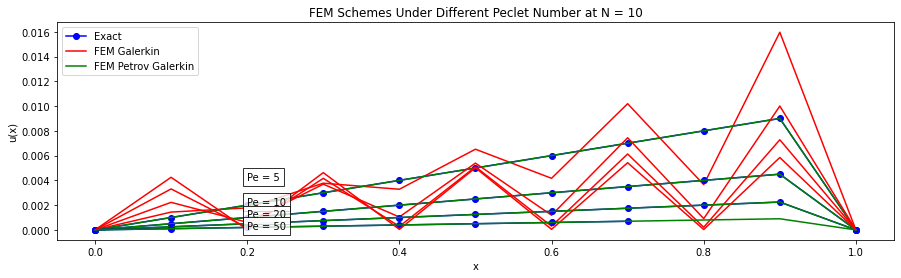

In [25]:
# Different Pe and Different Methods Plot

# Setup
mu = 1
s = 1
u0 = 0
uN = 0
N = 10

different_Pe_different_methods_Plot(mu, s, u0, uN, N, False)

The Peclet number is: 0.5


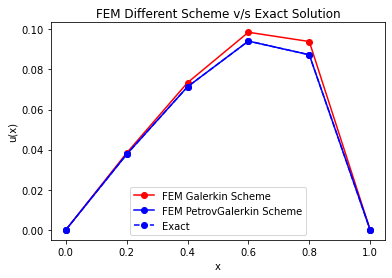

In [22]:
# -----------------Comparison of different schemes------------------#

# Setup
# Segmentation of the domain of interests
L = 1  # Length of the domain
N = 5  # Number of mesh points
h = L / N  # Mesh size (Delta_x)
xmesh = np.zeros(N)  # Mesh point
# Initialising an array of mesh points to locate each node
xmesh = list(i * h for i in range(len(xmesh) + 1))

# Source
s = 1

# Initialization of constants and parameters
a = 5
mu = 1
Pe = a * h / (2 * mu)
gamma = a / mu
beta = mpmath.coth(Pe) - 1 / Pe

mu_sub = beta * mu * Pe

tau = beta * h / (2 * abs(a))
print('The Peclet number is:', Pe)

# Boundary Conditions
u0 = 0
uN = 0

u_exact = exact_solver(a, mu, s, u0, uN, N)
u_Ga = FEM_Galerkin(a, mu, s, u0, uN, N)
u_PG = FEM_Petrov_Galerkin(a, mu, s, u0, uN, N)

plt.plot(xmesh, u_Ga, 'red', marker = 'o', label = 'FEM Galerkin Scheme')
plt.plot(xmesh, u_PG, 'blue', marker = 'o', label = 'FEM PetrovGalerkin Scheme')

plt.plot(xmesh, u_exact, 'blue', linestyle='--', marker = 'o', label = 'Exact')
plt.title('FEM Different Scheme v/s Exact Solution')
plt.xlabel('x')
plt.ylabel('u(x)')
plt.legend()
#plt.savefig('/Users/pc/Desktop/[P2] Convection-Diffusion Problem/Images Pool/Comparison of FEM Galerkin and Petrov-Galerkin Scheme at Pe = %s N = %s.png'%(Pe, N))
plt.show()